# Prediction of Average Salaries by Region in 2025-2026

In [1]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Output

## Clearing a table and creating a dataset

In [2]:
file_path = "/content/wages.xlsx"
data1 = pd.read_excel(file_path, sheet_name='2013-2018', skiprows=3)
data2 = pd.read_excel(file_path, sheet_name='с 2019', skiprows=2)

for df in [data1, data2]:
  df.iloc[:, 0] = df.iloc[:, 0].astype(str).str.strip()

In [3]:
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь',
          'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']

suffix_data1 = {'': 2013, '.1': 2014, '.2': 2015, '.3': 2016, '.4': 2017, '.5': 2018}
suffix_data2 = {'': 2019, '.1': 2020, '.2': 2021, '.3': 2022, '.4': 2023, '.5': 2023, '.6': 2024}

def get_salary(df, suffix_data):
  result = defaultdict(list)

  for _, row in df.iterrows():
    region = row.iloc[0]
    if not isinstance(region, str):
      continue
    region = region.strip()
    if "Кузбасс" in region:
      region = "Кемеровская область"
    if "в том числе" in region or "федеральный округ" in region or "1)" in region or "2)" in region:
      continue
    for col in df.columns[1:]:
      match = re.match(r'^(' + '|'.join(months) + r')(\.\d*)?$', col)
      if match:
        _, suffix = match.groups()
        suffix = suffix or ''
        year = suffix_data.get(suffix)
        if year:
          value = row[col]
          if pd.notna(value):
            result[(region, year)].append(value)

  rows = []
  for (region, year), values in result.items():
    if values:
      avg = sum(values)/len(values)
      rows.append((region, year, avg))

  return pd.DataFrame(rows, columns=['Region', 'Year', 'Mean_Wage'])

df1 = get_salary(data1, suffix_data1)
df2 = get_salary(data2, suffix_data2)

df_salary = pd.concat([df1, df2], ignore_index=True)
df_salary = df_salary.sort_values(by=['Region', 'Year']).reset_index(drop=True)

### The resulting table

In [4]:
df_salary.iloc[:]

,Region,Year,Mean_Wage
0,Алтайский край,2013,18116.933333
1,Алтайский край,2014,19456.933333
2,Алтайский край,2015,19959.758333
3,Алтайский край,2016,21039.441667
4,Алтайский край,2017,22733.493642
...,...,...,...
1035,г.Севастополь,2020,35660.991667
1036,г.Севастополь,2021,39127.000000
1037,г.Севастополь,2022,43732.833333
1038,г.Севастополь,2023,52720.900000


## Split into test and training samples

In [5]:
x = pd.get_dummies(df_salary[['Region', 'Year']])
y = df_salary['Mean_Wage']

In [6]:
flag = df_salary['Year'] >= 2017

xTrain = x[flag]
xTest = x[~flag]

yTrain = y[flag]
yTest = y[~flag]

## Keras model

### Training

In [7]:
xScaler = MinMaxScaler()
xTrainScaler = xScaler.fit_transform(xTrain)
xTestScaler = xScaler.transform(xTest)

yScaler = MinMaxScaler()
yTrainScaler = yScaler.fit_transform(yTrain.values.reshape(-1, 1))
yTestScaler = yScaler.transform(yTest.values.reshape(-1, 1))

xTrainLSTM = xTrainScaler.reshape(xTrainScaler.shape[0], 1, xTrainScaler.shape[1])
xTestLSTM = xTestScaler.reshape(xTestScaler.shape[0], 1, xTestScaler.shape[1])

In [8]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(xTrainLSTM.shape[1], xTrainLSTM.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(xTrainLSTM, yTrainScaler,
                    epochs=9,
                    batch_size=32,
                    validation_data=(xTestLSTM, yTestScaler))


Epoch 1/9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0356 - mae: 0.1361 - val_loss: 0.0118 - val_mae: 0.1022
Epoch 2/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - mae: 0.1025 - val_loss: 0.0105 - val_mae: 0.0972
Epoch 3/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - mae: 0.0918 - val_loss: 0.0057 - val_mae: 0.0702
Epoch 4/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - mae: 0.0796 - val_loss: 0.0031 - val_mae: 0.0497
Epoch 5/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mae: 0.0680 - val_loss: 0.0016 - val_mae: 0.0265
Epoch 6/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mae: 0.0501 - val_loss: 0.0012 - val_mae: 0.0233
Epoch 7/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0411 - val_loss: 7.8427e-04 - val_mae: 0.0205
Epoch 8/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0386 - val_loss: 7.6968e-04 - val_mae: 0.0211
Epoch 9/9
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mae: 0.0338 - v

### Error analysis

#### MSE & MAE Visualization

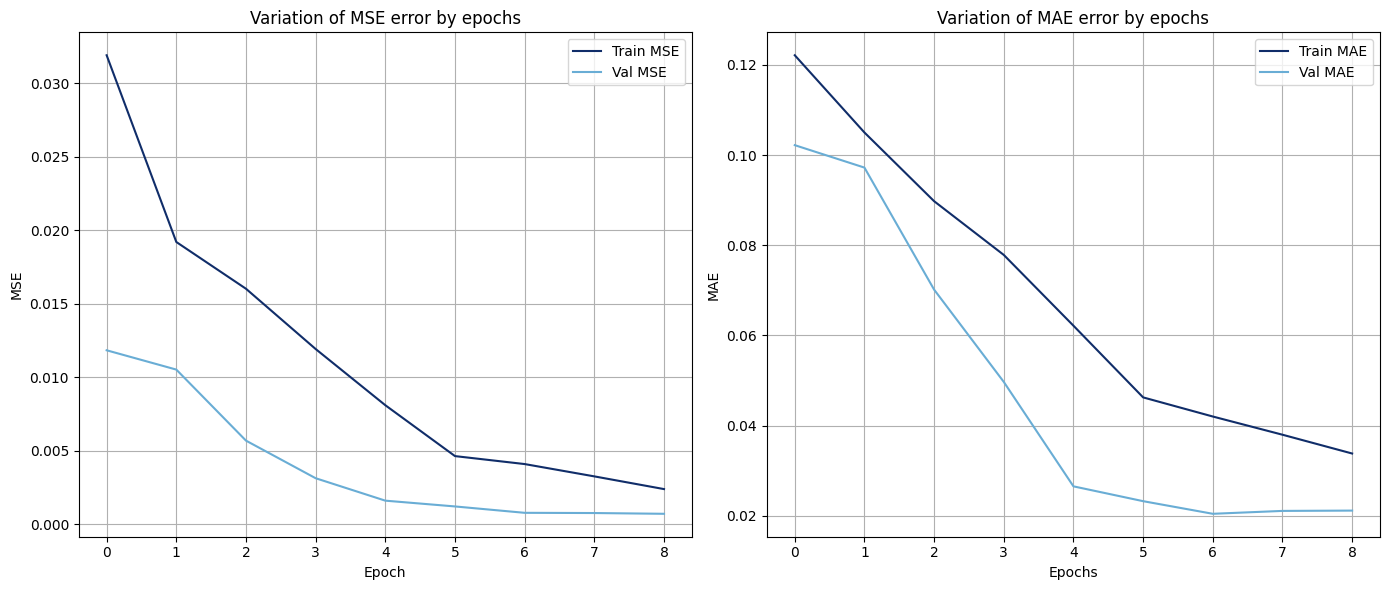

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(history.history['loss'], label='Train MSE', color='#102d69')
ax1.plot(history.history['val_loss'], label='Val MSE', color='#69add5')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_title('Variation of MSE error by epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['mae'], label='Train MAE', color='#102d69')
ax2.plot(history.history['val_mae'], label='Val MAE', color='#69add5')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.set_title('Variation of MAE error by epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Forecast for 2025-2026

In [10]:
y_pred_scaled = model.predict(xTestLSTM)
y_pred = yScaler.inverse_transform(y_pred_scaled)
y_true = yScaler.inverse_transform(yTestScaler)
mae = mean_absolute_error(y_true, y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


### Dataset Creation

In [11]:
future_years = [2025, 2026]
regions = df_salary['Region'].unique()

future_rows = []
for region in regions:
  for year in future_years:
    future_rows.append([region, year])

df_future_salaries = pd.DataFrame(future_rows, columns=['Region', 'Year'])

In [12]:
xFuture = pd.get_dummies(df_future_salaries)
xFuture = xFuture.reindex(columns=x.columns, fill_value=0)
xFutureScaler = xScaler.transform(xFuture)
xFutureLSTM = xFutureScaler.reshape(xFutureScaler.shape[0], 1, xFutureScaler.shape[1])

### The resulting table

In [13]:
df_future_salaries.iloc[:]

,Region,Year
0,Алтайский край,2025
1,Алтайский край,2026
2,Амурская область,2025
3,Амурская область,2026
4,Архангельская область,2025
...,...,...
169,г.Москва,2026
170,г.Санкт-Петербург,2025
171,г.Санкт-Петербург,2026
172,г.Севастополь,2025


### Predictions

In [14]:
yFutureScaler = model.predict(xFutureLSTM)
yFuture = yScaler.inverse_transform(yFutureScaler)
df_future_salaries['Forecast_Wage'] = yFuture

df_future_salaries['Min_Forecast_Wage'] = df_future_salaries['Forecast_Wage'] - mae
df_future_salaries['Max_Forecast_Wage'] = df_future_salaries['Forecast_Wage'] + mae

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


### Connecting Widgets

In [23]:
out = Output()

def show_salary(region, year):
  salary_info = df_future_salaries[(df_future_salaries['Region'] == region) & (df_future_salaries['Year'] == year)]

  if not salary_info.empty:
    print(f"Salary for region {region} in {year} year:")
    print("Forecast wage: %.2f rub." % salary_info['Forecast_Wage'].values[0])
    print("Error-adjusted minimum wage: %.2f rub." % salary_info['Min_Forecast_Wage'].values[0])
    print("Error-adjusted maximum wage: %.2f rub." % salary_info['Max_Forecast_Wage'].values[0])
  else:
    print("No data available for the selected region and year.")

  historical_data = df_salary[df_salary['Region'] == region]
  filtered_data = df_future_salaries[df_future_salaries['Region'] == region]
  filtered_data = filtered_data[filtered_data['Year'] <= year]

  full_data = pd.concat([historical_data[['Region', 'Year', 'Mean_Wage']],
                         filtered_data[['Region', 'Year', 'Forecast_Wage']].rename(columns={'Forecast_Wage': 'Mean_Wage'})], axis=0)
  full_data = full_data.sort_values(by=["Region", "Year"]).reset_index(drop=True)

  plt.figure(figsize=(12, 6))
  plt.plot(full_data['Year'], full_data['Mean_Wage'], marker = 'o', label='Mean Wage', color='#102d69')
  plt.title(f'Salary trend for region {region} from 2013 to {year} year')
  plt.xlabel('Year')
  plt.ylabel('Mean Wage, rub.')
  plt.grid(True)
  plt.xticks(range(2013, year + 1))
  plt.legend()
  plt.show()

In [24]:
region_dropdown = widgets.Dropdown(options=df_future_salaries['Region'].unique(),
                                   description='Region:',
                                   disabled=False)
year_dropdown = widgets.Dropdown(options=df_future_salaries['Year'].unique(),
                                 description='Year:',
                                 disabled=False)

interact(show_salary, region=region_dropdown, year=year_dropdown)

out

interactive(children=(Dropdown(description='Region:', options=('Алтайский край', 'Амурская область', 'Архангел…

Output()

## Conclusions and Visualization


### General table with past + forecast data

In [17]:
df_full_data = pd.concat([df_salary[['Region', 'Year', 'Mean_Wage']],
                         df_future_salaries[['Region', 'Year', 'Forecast_Wage', 'Min_Forecast_Wage', 'Max_Forecast_Wage']].rename(columns={'Forecast_Wage': 'Mean_Wage'})], axis=0)
df_full_data = df_full_data.sort_values(by=["Region", "Year"]).reset_index(drop=True)

df_full_data.iloc[:]

,Region,Year,Mean_Wage,Min_Forecast_Wage,Max_Forecast_Wage
0,Алтайский край,2013,18116.933333,NaN,NaN
1,Алтайский край,2014,19456.933333,NaN,NaN
2,Алтайский край,2015,19959.758333,NaN,NaN
3,Алтайский край,2016,21039.441667,NaN,NaN
4,Алтайский край,2017,22733.493642,NaN,NaN
...,...,...,...,...,...
1209,г.Севастополь,2022,43732.833333,NaN,NaN
1210,г.Севастополь,2023,52720.900000,NaN,NaN
1211,г.Севастополь,2024,60490.833333,NaN,NaN
1212,г.Севастополь,2025,63198.847656,59491.257812,66906.437500


#### Heat map by region for comparison

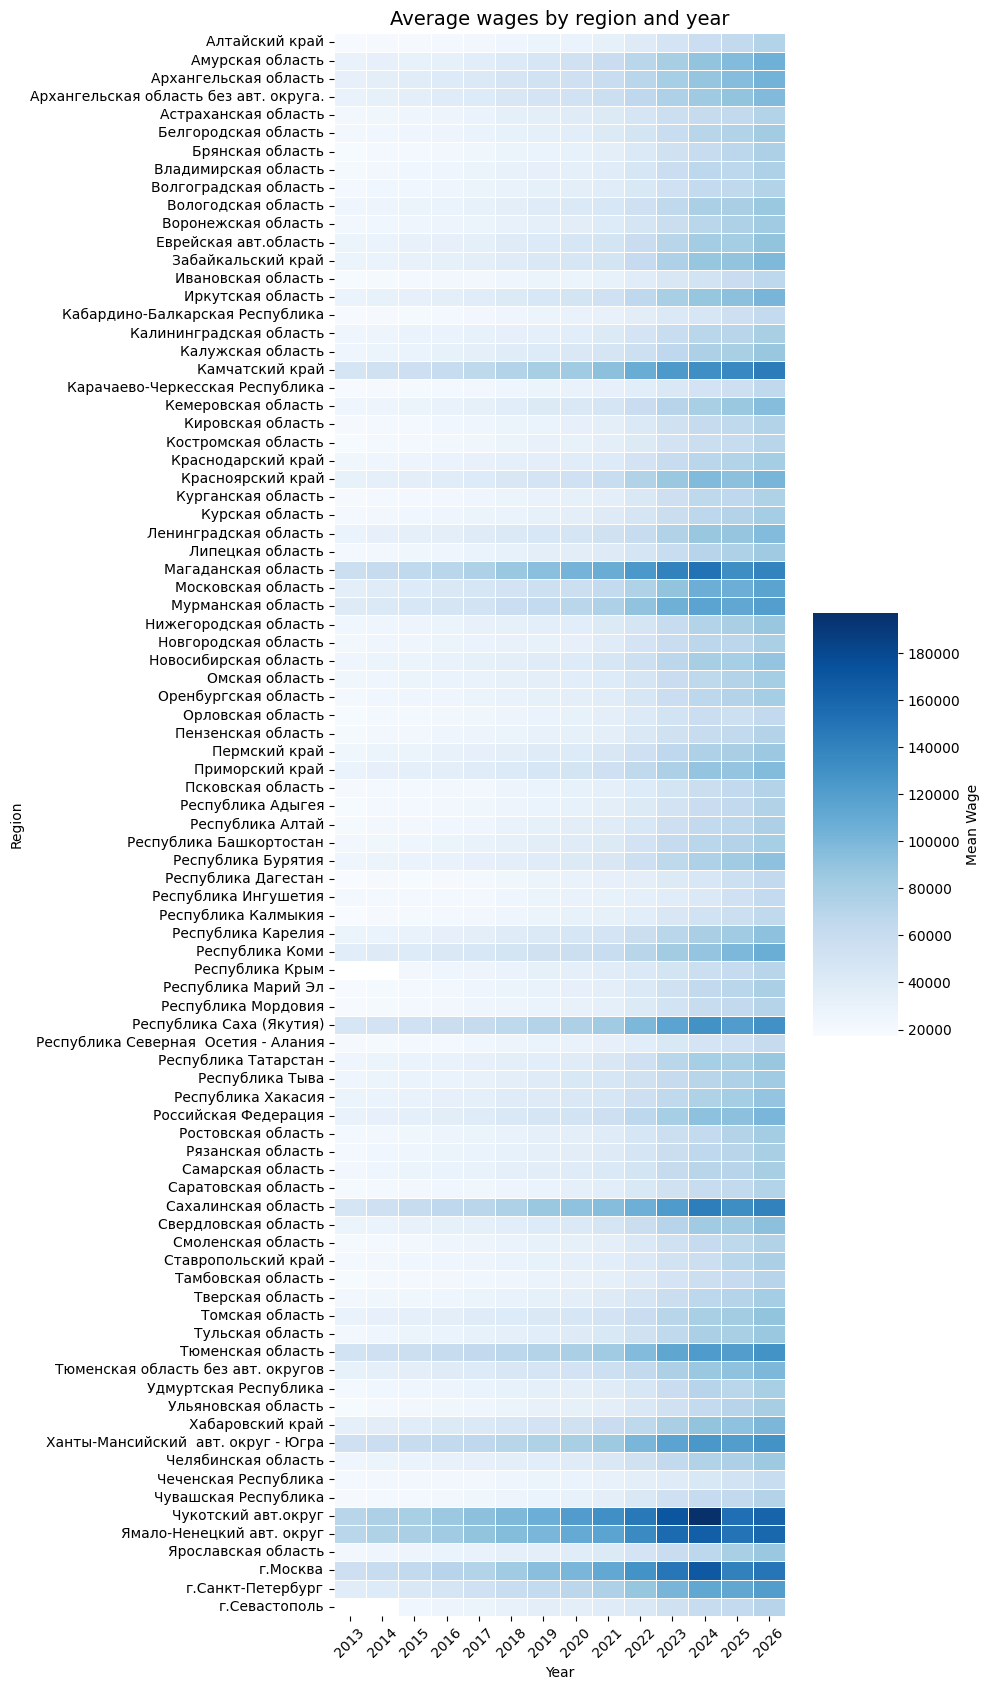

In [18]:
heatmap_data = df_full_data.pivot_table(columns='Year', index='Region', values='Mean_Wage')

plt.figure(figsize=(10, 17))
sns.heatmap(heatmap_data,
            cmap='Blues',
            linewidths=.5,
            cbar_kws={'label': 'Mean Wage', 'shrink': 0.5, 'aspect': 5})
plt.title('Average wages by region and year', fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Region', fontsize=10)
plt.tight_layout()
plt.show()


#### Распределение зп по годам с помощью боксплот

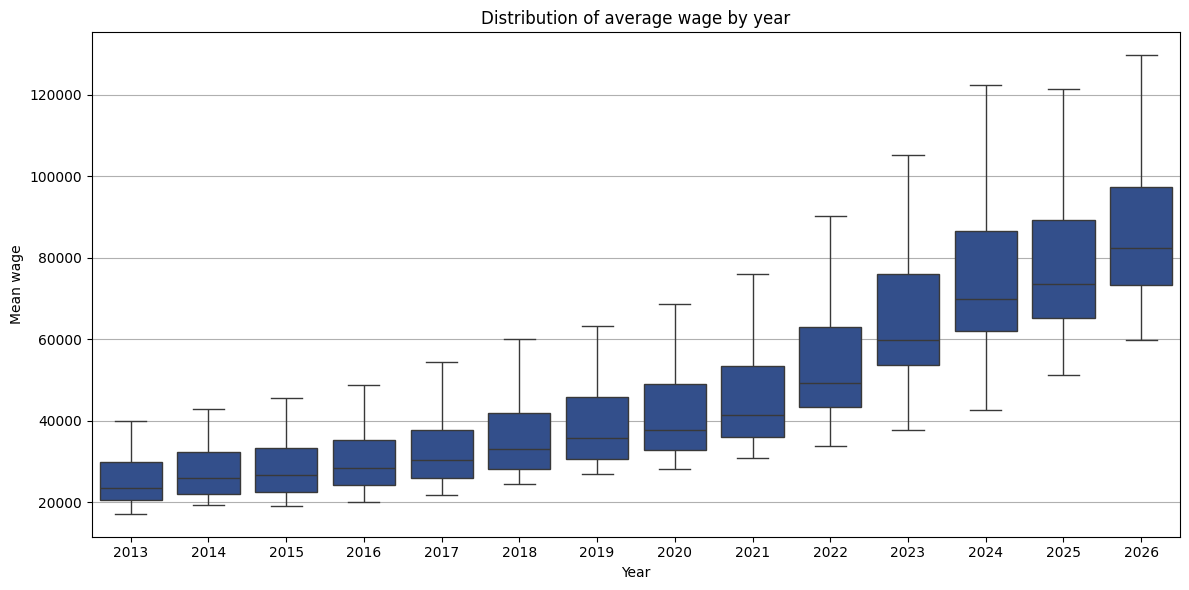

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_full_data, x='Year', y='Mean_Wage', showfliers=False, color='#244a9a')
plt.title('Distribution of average wage by year')
plt.xlabel('Year')
plt.ylabel('Mean wage')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Top 5 regions by salary in 2025 and 2026

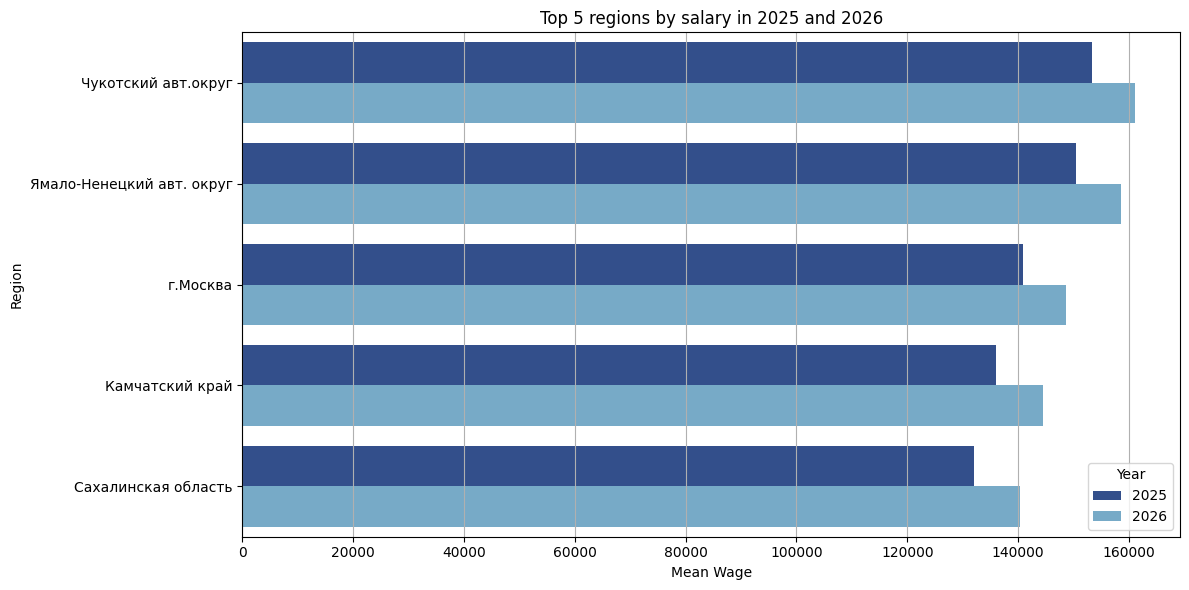

In [20]:
top_regions_2025 = df_full_data[df_full_data['Year'] == 2025].sort_values('Mean_Wage', ascending=False).head(5)
top_regions_2026 = df_full_data[df_full_data['Year'] == 2026].sort_values('Mean_Wage', ascending=False).head(5)

top_2025_2026 = pd.concat([top_regions_2025, top_regions_2026], ignore_index=True)

colors = ['#244a9a', '#69add5']
plt.figure(figsize=(12, 6))
sns.barplot(data=top_2025_2026, x='Mean_Wage', y='Region', hue='Year', palette=colors)
plt.title('Top 5 regions by salary in 2025 and 2026')
plt.xlabel('Mean Wage, rub')
plt.ylabel('Region')
plt.grid(axis='x')
plt.tight_layout()
plt.show()